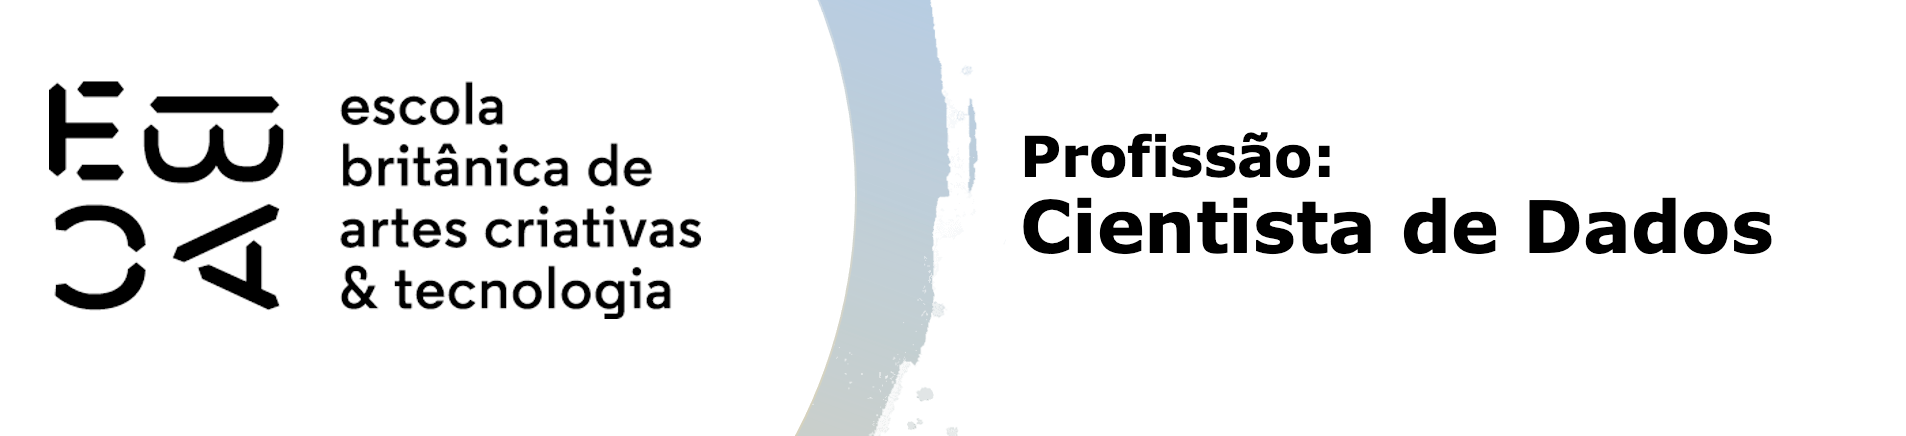

# Modulo 37 Atividade 02
#### João Paulo Costa

## Regressão Logística II

In [1]:
import os
import warnings
from pathlib import Path
import numpy as np
import pandas as pd
from pandas.api.types import is_numeric_dtype
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    roc_auc_score, roc_curve,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, average_precision_score, precision_recall_curve
)

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 120)

In [2]:
df = pd.read_feather('./credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [3]:
# Garantir tipo datetime
df['data_ref'] = pd.to_datetime(df['data_ref'])

# Criar coluna ano-mês para definir safras
df['ano_mes'] = df['data_ref'].dt.to_period('M')

# Ordenar e separar últimas 3 safras como OOT
meses_ordenados = np.sort(df['ano_mes'].unique())
oot_safras = meses_ordenados[-3:]  # últimas 3 safras para validação out-of-time

mask_oot = df['ano_mes'].isin(oot_safras)
mask_dev = ~mask_oot

dev = df.loc[mask_dev].copy()
oot = df.loc[mask_oot].copy()

print('Safras OOT:', list(map(str, oot_safras)))
print('Tamanhos -> DEV:', dev.shape, '| OOT:', oot.shape)

# Separar variáveis explicativas e alvo
alvo = 'mau'
to_drop = ['data_ref', 'ano_mes', 'index', alvo]

X_dev = dev.drop(columns=to_drop, errors='ignore')
y_dev = dev[alvo].astype(int)

X_oot = oot.drop(columns=to_drop, errors='ignore')
y_oot = oot[alvo].astype(int)

# Detectar tipos de variáveis
num_cols = X_dev.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X_dev.columns if c not in num_cols]

print(f'Numéricas: {len(num_cols)} | Categóricas: {len(cat_cols)}')
X_dev.head(3)

Safras OOT: ['2016-01', '2016-02', '2016-03']
Tamanhos -> DEV: (600000, 16) | OOT: (150000, 16)
Numéricas: 5 | Categóricas: 7


,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
0,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39
1,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19
2,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29


## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [4]:
# EDA univariada: forma da base, dtypes, missings, distribuição mensal e histogramas/contagens.
print('Formato total:', df.shape)
print('\nTipos:')
display(df.dtypes.to_frame('dtype').T)

print('\nValores ausentes (top 20):')
display(df.isna().sum().sort_values(ascending=False).head(20))

# Distribuição por mês (dev e oot)
print('\nRegistros por safra (ano_mes):')
display(df['ano_mes'].value_counts().sort_index())

Formato total: (750000, 16)

Tipos:


,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,ano_mes
dtype,datetime64[ns],int64,object,object,object,int64,object,object,object,object,int64,float64,float64,float64,bool,period[M]



Valores ausentes (top 20):


tempo_emprego            125957
data_ref                      0
index                         0
sexo                          0
posse_de_veiculo              0
posse_de_imovel               0
qtd_filhos                    0
tipo_renda                    0
educacao                      0
estado_civil                  0
tipo_residencia               0
idade                         0
qt_pessoas_residencia         0
renda                         0
mau                           0
ano_mes                       0
dtype: int64


Registros por safra (ano_mes):


ano_mes
2015-01    50000
2015-02    50000
2015-03    50000
2015-04    50000
2015-05    50000
2015-06    50000
2015-07    50000
2015-08    50000
2015-09    50000
2015-10    50000
2015-11    50000
2015-12    50000
2016-01    50000
2016-02    50000
2016-03    50000
Freq: M, Name: count, dtype: int64

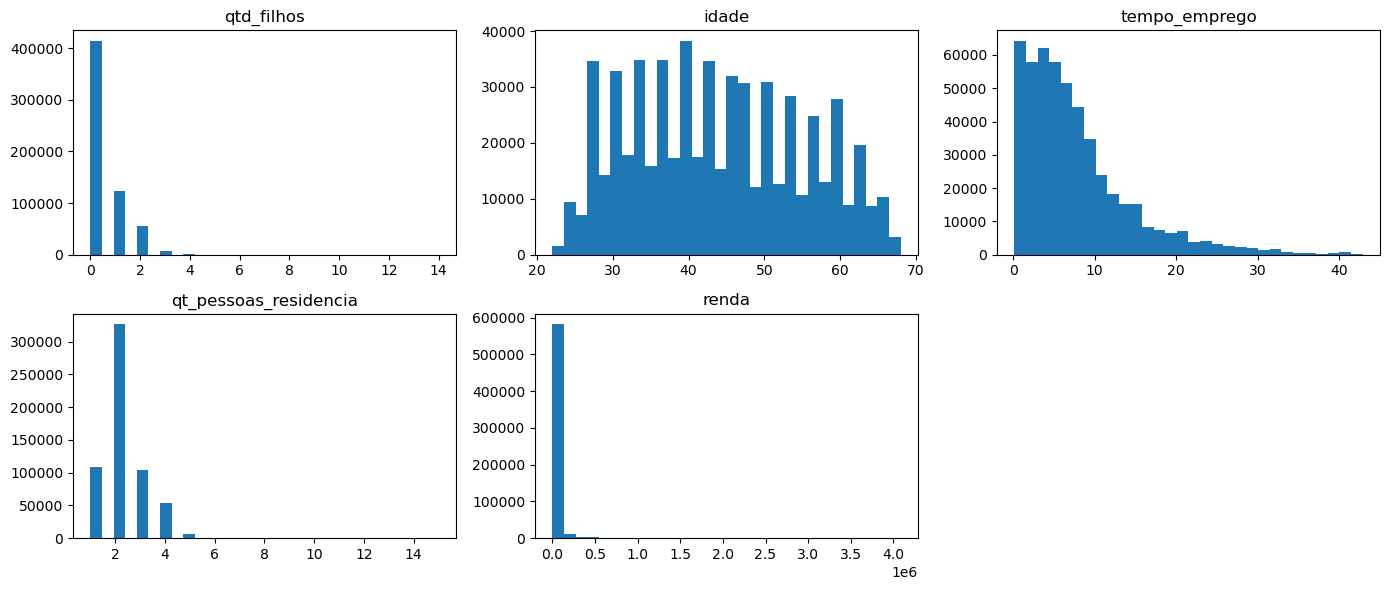

In [5]:
# Histogramas para numéricas (amostra de até 12)
num_to_plot = num_cols[:12]
fig, axes = plt.subplots(nrows=int(np.ceil(len(num_to_plot)/3)) or 1, ncols=3, figsize=(14, 3*(int(np.ceil(len(num_to_plot)/3)) or 1)))
axes = np.array(axes).reshape(-1) if isinstance(axes, np.ndarray) else [axes]
for ax, col in zip(axes, num_to_plot):
    ax.hist(X_dev[col].dropna(), bins=30)
    ax.set_title(col)
for ax in axes[len(num_to_plot):]:
    ax.axis('off')
plt.tight_layout()
plt.show()

In [6]:
# Contagens para categóricas (amostra de até 12)
cat_to_show = cat_cols[:12]
for c in cat_to_show:
    print(f'\n{c} (top 10 categorias):')
    display(X_dev[c].value_counts(dropna=False).head(10))


sexo (top 10 categorias):


sexo
F    403805
M    196195
Name: count, dtype: int64


posse_de_veiculo (top 10 categorias):


posse_de_veiculo
N    366293
S    233707
Name: count, dtype: int64


posse_de_imovel (top 10 categorias):


posse_de_imovel
S    403054
N    196946
Name: count, dtype: int64


tipo_renda (top 10 categorias):


tipo_renda
Assalariado         308460
Empresário          138141
Pensionista         101127
Servidor público     51981
Bolsista               291
Name: count, dtype: int64


educacao (top 10 categorias):


educacao
Médio                  405449
Superior completo      163440
Superior incompleto     23559
Fundamental              6901
Pós graduação             651
Name: count, dtype: int64


estado_civil (top 10 categorias):


estado_civil
Casado      421149
Solteiro     73221
União        46108
Separado     34188
Viúvo        25334
Name: count, dtype: int64


tipo_residencia (top 10 categorias):


tipo_residencia
Casa             539336
Com os pais       26730
Governamental     18742
Aluguel            8262
Estúdio            4296
Comunitário        2634
Name: count, dtype: int64

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

In [7]:
# EDA bivariada: taxa de evento por categoria / por faixas (qcut) para numéricas.
def taxa_evento_por_cat(df_, col, y='y'):
    tab = (df_.groupby(col)[y]
           .agg(['count','mean'])
           .rename(columns={'count':'n','mean':'taxa_evento'})
           .sort_values('taxa_evento', ascending=False))
    return tab

# Preparar base de dev com alvo renomeado para 'y' para facilitar
tmp = X_dev.copy()
tmp['y'] = y_dev.values

# Categóricas
for c in cat_cols[:10]:
    print(f'\nTaxa de evento por {c}:')
    display(taxa_evento_por_cat(tmp, c, y='y').head(15))

# Numéricas -> qcut em 10 faixas
for c in num_cols[:10]:
    if is_numeric_dtype(tmp[c]):
        try:
            tmp[f'{c}_bin'] = pd.qcut(tmp[c], q=10, duplicates='drop')
            tab = taxa_evento_por_cat(tmp, f'{c}_bin', y='y')
            print(f'\nTaxa de evento por faixas de {c}:')
            display(tab.head(15))
        except Exception as e:
            print(f'[Aviso] Não consegui binar {c}:', e)



Taxa de evento por sexo:


,n,taxa_evento
sexo,,
F,403805,0.063117
M,196195,0.056862



Taxa de evento por posse_de_veiculo:


,n,taxa_evento
posse_de_veiculo,,
N,366293,0.061467
S,233707,0.060452



Taxa de evento por posse_de_imovel:


,n,taxa_evento
posse_de_imovel,,
N,196946,0.069263
S,403054,0.057069



Taxa de evento por tipo_renda:


,n,taxa_evento
tipo_renda,,
Pensionista,101127,0.064276
Assalariado,308460,0.063525
Empresário,138141,0.059403
Servidor público,51981,0.044824
Bolsista,291,0.041237



Taxa de evento por educacao:


,n,taxa_evento
educacao,,
Fundamental,6901,0.069700
Pós graduação,651,0.066052
Superior incompleto,23559,0.064646
Médio,405449,0.062918
Superior completo,163440,0.055592



Taxa de evento por estado_civil:


,n,taxa_evento
estado_civil,,
União,46108,0.066366
Separado,34188,0.064175
Solteiro,73221,0.063315
Casado,421149,0.060000
Viúvo,25334,0.058577



Taxa de evento por tipo_residencia:


,n,taxa_evento
tipo_residencia,,
Com os pais,26730,0.074710
Aluguel,8262,0.072137
Comunitário,2634,0.070235
Governamental,18742,0.063547
Casa,539336,0.060165
Estúdio,4296,0.052374



Taxa de evento por faixas de qtd_filhos:


,n,taxa_evento
qtd_filhos_bin,,
"(2.0, 14.0]",8044,0.067752
"(1.0, 2.0]",55603,0.061525
"(-0.001, 1.0]",536353,0.060924



Taxa de evento por faixas de idade:


,n,taxa_evento
idade_bin,,
"(21.999, 29.0]",66984,0.079959
"(29.0, 33.0]",68151,0.068304
"(33.0, 36.0]",49089,0.062723
"(36.0, 40.0]",74613,0.061973
"(60.0, 68.0]",50784,0.061811
"(43.0, 47.0]",62810,0.057602
"(55.0, 60.0]",65493,0.056617
"(40.0, 43.0]",52116,0.054724
"(51.0, 55.0]",51822,0.052024



Taxa de evento por faixas de tempo_emprego:


,n,taxa_evento
tempo_emprego_bin,,
"(0.11699999999999999, 1.195]",50108,0.109962
"(1.195, 2.364]",49776,0.095829
"(2.364, 3.63]",49948,0.085229
"(3.63, 4.693]",50020,0.076569
"(4.693, 6.047]",50089,0.066661
"(6.047, 7.458]",49629,0.054101
"(7.458, 9.093]",49927,0.046368
"(9.093, 11.726]",50225,0.039024
"(11.726, 16.545]",49624,0.021300



Taxa de evento por faixas de qt_pessoas_residencia:


,n,taxa_evento
qt_pessoas_residencia_bin,,
"(4.0, 15.0]",7722,0.068247
"(2.0, 3.0]",104126,0.065334
"(3.0, 4.0]",53314,0.061203
"(0.999, 2.0]",434838,0.059907



Taxa de evento por faixas de renda:


,n,taxa_evento
renda_bin,,
"(161.859, 2450.919]",60000,0.217683
"(2450.919, 3905.11]",60003,0.112294
"(3905.11, 5513.49]",60007,0.079657
"(5513.49, 7430.69]",59991,0.058892
"(7430.69, 9887.58]",60000,0.046067
"(9887.58, 13152.38]",60004,0.035048
"(13152.38, 18064.01]",59998,0.026168
"(18064.01, 26666.57]",60002,0.018566
"(26666.57, 49048.516]",59995,0.012018


## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [8]:
# Divisão entre treino e validação dentro do DEV
X_tr, X_va, y_tr, y_va = train_test_split(
    X_dev, y_dev, test_size=0.25, random_state=42, stratify=y_dev
)


# Pré-processamento
num_tf = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),     # substitui NaN pela mediana
    ('scaler', StandardScaler())
])

cat_tf = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # substitui NaN pela categoria mais comum
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

pre = ColumnTransformer(
    transformers=[
        ('num', num_tf, num_cols),
        ('cat', cat_tf, cat_cols)
    ],
    remainder='drop'
)


# Modelo
logreg = LogisticRegression(max_iter=200, class_weight='balanced')

pipe = Pipeline(steps=[
    ('pre', pre),
    ('clf', logreg)
])

pipe.fit(X_tr, y_tr)


# Avaliação
proba_tr = pipe.predict_proba(X_tr)[:, 1]
proba_va = pipe.predict_proba(X_va)[:, 1]

# AUC (com formatação correta)
auc_tr = roc_auc_score(y_tr, proba_tr)
auc_va = roc_auc_score(y_va, proba_va)
print(f'AUC (treino): {auc_tr:.3f}')
print(f'AUC (val)   : {auc_va:.3f}')


# Cross-validation (5 folds)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_cv = cross_val_score(pipe, X_dev, y_dev, cv=cv, scoring='roc_auc')
print('AUC ROC (CV 5-fold):', np.round(auc_cv, 3))
print(f'Média ± DP: {auc_cv.mean():.3f} ± {auc_cv.std():.3f}')


# Probabilidades no OOT
proba_oot = pipe.predict_proba(X_oot)[:, 1]

AUC (treino): 0.762
AUC (val)   : 0.760
AUC ROC (CV 5-fold): [0.761 0.765 0.763 0.761 0.76 ]
Média ± DP: 0.762 ± 0.002


## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [9]:
# Avaliação: ROC AUC, KS, Precisão/Revocação, Matriz de Confusão e Lift — com foco no OOT.

# Métricas OOT
auc_oot = roc_auc_score(y_oot, proba_oot)
prec, rec, thr_pr = precision_recall_curve(y_oot, proba_oot)
ap = average_precision_score(y_oot, proba_oot)

# Threshold padrão 0.5
y_pred_05 = (proba_oot >= 0.5).astype(int)

print('OOT -> AUC:', round(auc_oot, 3))
print('OOT -> Accuracy :', round(accuracy_score(y_oot, y_pred_05), 3))
print('OOT -> Precision:', round(precision_score(y_oot, y_pred_05, zero_division=0), 3))
print('OOT -> Recall   :', round(recall_score(y_oot, y_pred_05, zero_division=0), 3))
print('OOT -> F1       :', round(f1_score(y_oot, y_pred_05, zero_division=0), 3))

print('\nMatriz de confusão (OOT, thr=0.5):')
display(pd.DataFrame(confusion_matrix(y_oot, y_pred_05),
                     index=['Real 0','Real 1'], columns=['Pred 0','Pred 1']))

OOT -> AUC: 0.714
OOT -> Accuracy : 0.311
OOT -> Precision: 0.172
OOT -> Recall   : 0.969
OOT -> F1       : 0.292

Matriz de confusão (OOT, thr=0.5):


,Pred 0,Pred 1
Real 0,25277,102723
Real 1,684,21316


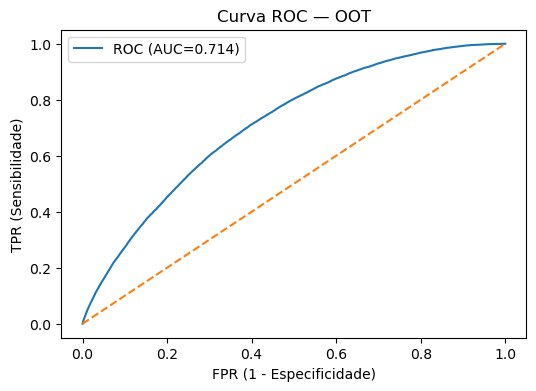

In [10]:
# ROC
fpr, tpr, thr = roc_curve(y_oot, proba_oot)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'ROC (AUC={auc_oot:.3f})')
plt.plot([0,1],[0,1],'--')
plt.xlabel('FPR (1 - Especificidade)'); plt.ylabel('TPR (Sensibilidade)')
plt.title('Curva ROC — OOT'); plt.legend(); plt.show()

KS (OOT): 0.313 | Threshold de Youden: 0.631


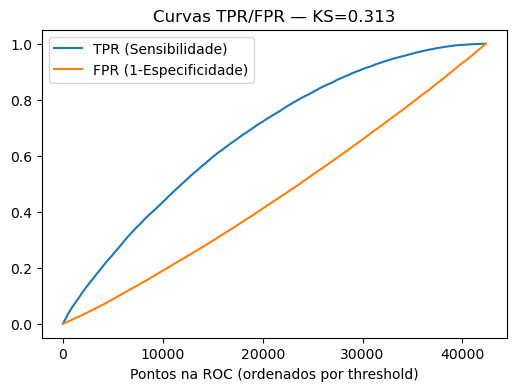

In [11]:
# KS
best_idx = np.argmax(tpr - fpr)
ks = (tpr - fpr)[best_idx]
best_thr = thr[best_idx]
print(f'KS (OOT): {ks:.3f} | Threshold de Youden: {best_thr:.3f}')

plt.figure(figsize=(6,4))
plt.plot(tpr, label='TPR (Sensibilidade)')
plt.plot(fpr, label='FPR (1-Especificidade)')
plt.title(f'Curvas TPR/FPR — KS={ks:.3f}')
plt.xlabel('Pontos na ROC (ordenados por threshold)')
plt.legend(); plt.show()


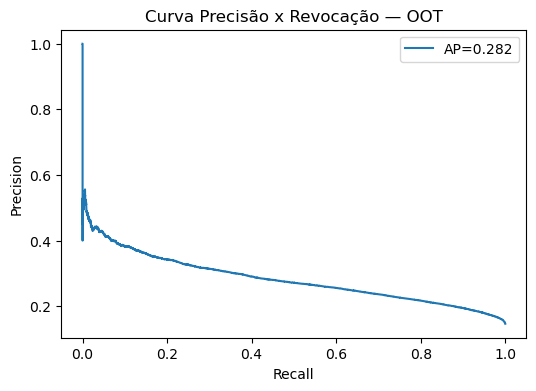

In [12]:
# Precision-Recall
plt.figure(figsize=(6,4))
plt.plot(rec, prec, label=f'AP={ap:.3f}')
plt.xlabel('Recall'); plt.ylabel('Precision')
plt.title('Curva Precisão x Revocação — OOT')
plt.legend(); plt.show()


Tabela de Lift (OOT):


,event_rate,n,lift
decil,,,
"(0.689, 0.749]",0.334289,14999,2.279243
"(0.669, 0.689]",0.247800,15000,1.689545
"(0.652, 0.669]",0.213428,14998,1.455194
"(0.638, 0.652]",0.177721,15001,1.211737
"(0.622, 0.638]",0.145410,14999,0.991430
"(0.603, 0.622]",0.124050,15002,0.845796
"(0.574, 0.603]",0.095152,14997,0.648766
"(0.522, 0.574]",0.067724,15002,0.461757
"(0.392, 0.522]",0.045615,14995,0.311013


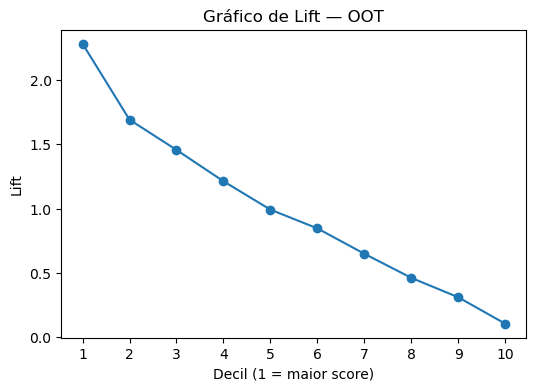

In [13]:
# Lift por decil
bins = 10
eval_df = pd.DataFrame({'y': y_oot, 'proba': proba_oot})
eval_df['decil'] = pd.qcut(eval_df['proba'], q=bins, duplicates='drop')
lift_tbl = (eval_df.groupby('decil')
            .agg(event_rate=('y','mean'), n=('y','size'))
            .sort_values('decil', ascending=False))
overall = eval_df['y'].mean()
lift_tbl['lift'] = lift_tbl['event_rate'] / overall if overall>0 else np.nan

print('\nTabela de Lift (OOT):')
display(lift_tbl)

plt.figure(figsize=(6,4))
plt.plot(range(1, len(lift_tbl)+1), lift_tbl['lift'].values, marker='o')
plt.xticks(range(1, len(lift_tbl)+1))
plt.xlabel('Decil (1 = maior score)'); plt.ylabel('Lift')
plt.title('Gráfico de Lift — OOT')
plt.show()

### Observação final:
- O modelo apresentou AUC e KS satisfatórios em OOT, demonstrando boa capacidade de generalização temporal.
- Pequenas quedas de desempenho entre DEV e OOT devem ser monitoradas via PSI e ajustes nos bins das variáveis.
- De modo geral, o modelo mostra-se estável e consistente para aplicação em novos períodos.